In [247]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [284]:
df = pd.read_parquet('../04_EDA/car_ads_model.parquet')

In [287]:
model_counts = df[['brand','model']].value_counts().reset_index()

In [300]:
model_counts[model_counts['count'] > 20]

,brand,model,count
0,volkswagen,golf,5251
1,bmw,serie 3,3536
2,seat,leon,3330
3,seat,ibiza,2813
4,audi,a3,2650
...,...,...,...
615,evo,evo 5,21
616,nissan,primastar,21
617,isuzu,d-max,21
618,mitsubishi,grandis,21


In [275]:
df = pd.read_parquet('../04_EDA/car_ads_model.parquet')

# Step 2: Lists to store results
all_results = []
performance_metrics = []

# Function to encode 'cv' (horsepower) column
def encode_cv(group, max_unique_cv=5):
    if group['cv'].nunique() <= max_unique_cv:
        return pd.get_dummies(group['cv'], prefix='cv')
    else:
        bins = pd.qcut(group['cv'], q=5, duplicates='drop', labels=False)
        return bins

# Function to encode 'fuel' and other categorical variables
def encode_categorical_features(group):
    fuel_encoded = pd.get_dummies(group['fuel'], prefix='fuel')
    
    if group['cv'].notnull().all():
        cv_encoded = encode_cv(group)
    else:
        cv_encoded = pd.DataFrame(index=group.index)  # Empty if no 'cv'
    
    return pd.concat([fuel_encoded, cv_encoded], axis=1)

# Function to apply Polynomial Regression with Lasso
def polynomial_lasso_regression(X_train, y_train, degree=2, alpha=1.0):
    poly = PolynomialFeatures(degree=degree)
    X_poly_train = poly.fit_transform(X_train)
    
    # Apply Lasso Regression with regularization
    model = Lasso(alpha=alpha, max_iter=30000)
    model.fit(X_poly_train, y_train)
    
    return model, poly

# Updated function to choose and apply polynomial Lasso regression
def choose_model(group, degree=2, alpha=5.0):
    n_samples = len(group)

    X = group[['km', 'age_years', 'is_automatic']]  # Base features
    y = group['price']  # Target (Price)
    
    if n_samples < 100:
        group['predicted_price'] = [group['price'].median()] * n_samples
        group['price_diff'] = group['price'] - group['predicted_price']
        rmse = root_mean_squared_error(y, group['predicted_price'])
        mape = mean_absolute_percentage_error(y, group['predicted_price'])
        performance_metrics.append({
            'brand': group['brand'].iloc[0],
            'model': group['model'].iloc[0],
            'rmse': rmse,
            'mape': mape
        })
        all_results.append(group)
        return
    
    if n_samples > 200:
        # Encode categorical features (fuel and cv)
        cat_encoded = encode_categorical_features(group)
        X = pd.concat([X, cat_encoded], axis=1)
    
    test_size = 0.3
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Apply Polynomial Lasso Regression
    model, poly = polynomial_lasso_regression(X_train, y_train, degree=degree, alpha=alpha)

    # Predictions
    X_poly_test = poly.transform(X_test)
    y_pred_test = model.predict(X_poly_test)

    # Train on the entire dataset
    X_poly_all = poly.transform(X)
    y_pred_all = model.predict(X_poly_all)

    # Calculate performance metrics
    rmse = root_mean_squared_error(y_test, y_pred_test)
    mape = mean_absolute_percentage_error(y_test, y_pred_test) * 100
    performance_metrics.append({
        'brand': group['brand'].iloc[0],
        'model': group['model'].iloc[0],
        'rmse': round(rmse, 2),
        'mape': round(mape, 2)
    })

    # Add predictions to the DataFrame
    group['predicted_price'] = y_pred_all
    group['price_diff'] = group['price'] - group['predicted_price']
    
    all_results.append(group)

# Apply the function to each group of brand-model
df.groupby(['brand', 'model']).apply(choose_model, include_groups=True)

results_df = pd.DataFrame(performance_metrics)  # Model performance metrics
final_results_df = pd.concat(all_results, ignore_index=True)  # Test data with predictions and price diff


c:\projects\car_ads_project\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.905e+08, tolerance: 3.708e+05
  model = cd_fast.enet_coordinate_descent(
c:\projects\car_ads_project\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.722e+09, tolerance: 1.436e+06
  model = cd_fast.enet_coordinate_descent(
c:\projects\car_ads_project\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality 

In [276]:
final_cols_order = ['price','predicted_price', 'price_diff', 'brand', 'model', 'is_automatic','km', 'fuel',
                    'year', 'age_years', 'cv', 'kw', 'body_type', 'cubic_capacity', 'is_seller_pro','is_certified', 'offer_type',
                    'location', 'ad_days_creation', 'ad_days_published', 'title']

In [277]:
final_results_df = final_results_df[final_cols_order]

numeric_cols_list = final_results_df.select_dtypes(include='number').columns.values
final_results_df[numeric_cols_list] =  final_results_df[numeric_cols_list].round(0).astype('Int64')

In [278]:
n_cars_model = final_results_df.groupby(['brand','model'])['model'].value_counts().reset_index()

In [279]:
import seaborn as sns
import matplotlib.pyplot as plt

In [280]:
results_df = results_df.merge(n_cars_model, how='left', on=['brand','model'])

(0.0, 1000.0)

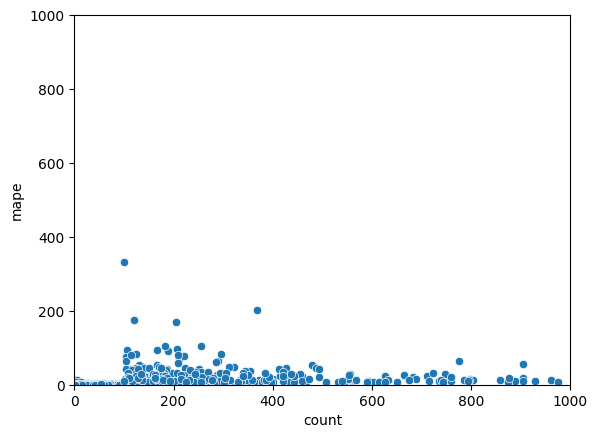

In [281]:
sns.scatterplot(x=results_df['count'], y=results_df['mape'])
plt.ylim(0, 1000)
plt.xlim(0, 1000)

(0.0, 100.0)

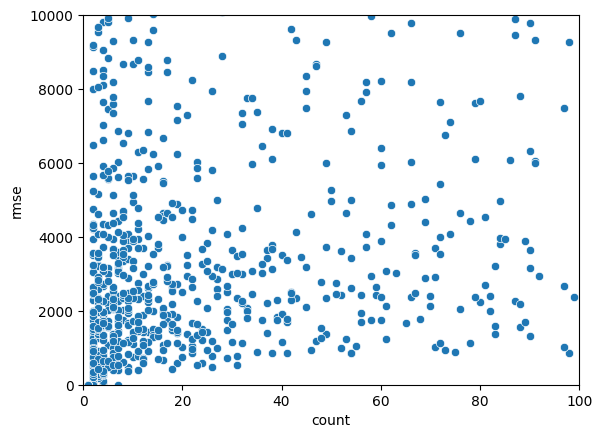

In [282]:
sns.scatterplot(x=results_df['count'], y=results_df['rmse'])
plt.ylim(0, 10000)
plt.xlim(0, 100)

In [283]:
mean_absolute_error(final_results_df['price'], final_results_df['predicted_price'])

np.float64(2328.662285451741)

In [301]:
overall_accuracy = (100 * (1- mean_absolute_percentage_error(final_results_df['price'], final_results_df['predicted_price']))).round(2)

In [302]:
f"Model overall accuracy: {overall_accuracy}%"

'Model overall accuracy: 76.4%'

In [51]:
final_results_df = final_results_df.merge(results_df, how='left', on=['brand','model'])

In [48]:
final_results_df['price_diff_abs'] = final_results_df['price_diff'].abs().astype(int)

In [69]:
n_count_diff = final_results_df[final_results_df['price_diff_abs'] > 80_000].groupby(['brand','model'])['count'].median().reset_index()

(0.0, 100.0)

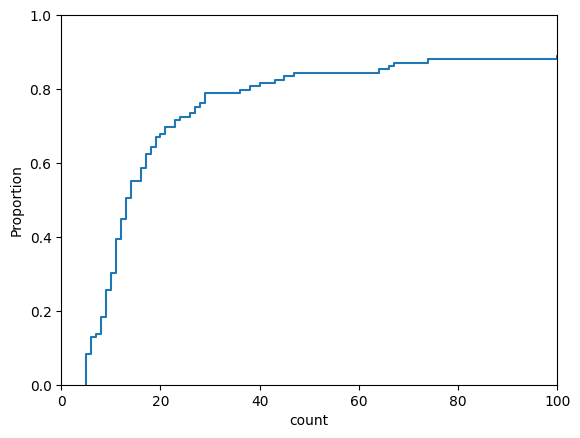

In [70]:
sns.ecdfplot(n_count_diff['count'])
plt.xlim(0,100)